In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
%matplotlib inline

# Linear regression

The general equation for linear regression has the form:  
$$y=\theta_0 +\theta_1\times x_1 +... + \theta_n\times x_n$$

If we consider a variable $x_0$ defined as $x_0=1$, then we can rewrite this equation with the form:
$$y=\theta_0\times x_0 +\theta_1\times x_1 +... + \theta_n\times x_n$$

If we have a very simple model $y=\theta_0 +\theta_1\times x_1$ to predict the price of a house based on its size for example, we could write a very simple function to make such a prediction:

In [2]:
# theta: parameters of the line, intercept/slope
# features: in this case, just the size
def predict(theta, features):
    features = np.concatenate([[1], features]) # add x_0 = 1
    return np.sum([t*f for t,f in zip(theta, features)])

theta = np.array([3, 8]) # the parameters of the line in this case, intercept/slope
features = np.array([2018]) # the value for which we want to predict the value

predict(theta, features)

16147

We can do better. The problem with writting a function like that is that it does not really scale up well if we have multiple features or a bigger dataset (we have a for loop).

Instead of using a function, we can simply make use of linear algebra and matrices multiplication to calculate the predicted price. This will allow us to calculate the prediction for different sets of $\theta$ and different training examples (no need for "for-loops constructs").

For two matrices of shapes (M x N) and (N x K) (the dimension N has to be the same), then their multiplication (dot product) (M x N).(N x K) will give a (M x K) matrix.

We are aiming for the dot product of our features vector by our theta vector, so we need to make sure the sizes are in agreement. Unsing numpy we have several options:
- `np.dot` if both vectors are numpy arrays. In this case we need to reshape our theta vector to be a (2x1) vector
- as of Python 3.5, numpy supports infix matrix multiplication between numpy arrays using the `@` operator, this would be the same than using `np.matmul`.
- convert both our vectors as matrices and use matrix multiplication using `*`

**Notes**:
`np.matmul` differs from `np.dot` in two important ways:
- Multiplication by scalars is not allowed.
- Stacks of matrices are broadcast together as if the matrices were elements.

For `np.matmul`: If either argument is N-D, N > 2, it is treated as a stack of matrices residing in the last two indexes and broadcast accordingly.

For `np.dot`: For 2-D arrays it is equivalent to matrix multiplication, and for 1-D arrays to inner product of vectors (without complex conjugation). For N dimensions it is a sum product over the last axis of a and the second-to-last of b

An advantage of using numpy arrays over matrices is that you'll be able to perform both dot product and element-wise products without calling special functions.

Let's prepare both of our vectors then:

### Using numpy arrays:

In [3]:
# Those have the same results:
theta = np.array([3, 8]).reshape((2, 1))
theta = np.array([3, 8])[:, np.newaxis]

features = np.array([1, 2018])

print(np.dot(features, theta))
print(np.matmul(features, theta))
print(features@theta)

[16147]
[16147]
[16147]


### Using numpy matrices

In [4]:
# Those have the same results:
theta = np.matrix([[3], [8]])
theta = np.matrix([3, 8]).transpose()

features = np.matrix([1, 2018])

features*theta

matrix([[16147]])

Great, we have some linear algebra working in Python. Now we can efficiently compute prediction for different sets of $\theta$ and different training examples (only one feature in this case, the house size):

In [5]:
houseSizes = np.array([2104, 1416, 1534, 852])
features = np.vstack([np.ones(len(houseSizes)), houseSizes]).transpose()

features

array([[1.000e+00, 2.104e+03],
       [1.000e+00, 1.416e+03],
       [1.000e+00, 1.534e+03],
       [1.000e+00, 8.520e+02]])

In [6]:
# Let's get different houses sizes for which we want to predict the price 
houseSizes = np.array([2104, 1416, 1534, 852])
# From them, let's make a proper (4x2) matrix, adding the x_0=1 to every example
features = features = np.vstack([np.ones(len(houseSizes)), houseSizes]).transpose()

# 3 different [intercept, slope] pairs, (2x3) matrix
theta = np.array([[-40, 0.25], [200, 0.1], [-150, 0.4]]).transpose()

# predictions for each house (rows), for each [int, slope] pairs (columns), using matrices multiplication.
# all are equivalent
np.matmul(features, theta)
np.dot(features, theta)
features@theta

array([[486. , 410.4, 691.6],
       [314. , 341.6, 416.4],
       [343.5, 353.4, 463.6],
       [173. , 285.2, 190.8]])

# Cost function

Alright, we now know how to compute the predictions based on know parameters ($\theta$ vector).
Now, let's see how we could obtain those parameters by fitting our linear model to a dataset.

For this, we need to define a cost function of the form:
$J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(h_0(x^{(i)})-y^{(i)})^2$

with $h_0(x)=\hat{y}$ being our predictive function that we worked with above $h_0(x) = \sum_{j=0}^{n} \theta_i\times x_j$.

- $m$ is the number of training data we have
- $n$ is the polynomial degree for our regression (in our case, we are using a line so far, so $n=1$)
- $y$ is the true value that we are trying to predict with our $h_0(x)$ function

In [7]:
# If theta and features and trueValues are correctly shaped matrices, then we can define the cost function as
def computeCost(theta, features, trueValues):
    predictions = np.dot(features, theta) # this is a (number of features x number of Theta vectors) matrix
    error = (predictions-trueValues)**2 # if you're inputing a matrice, this won't perform an element-wise square, use np.power instead
    return np.sum(error, axis=0)/(2*features.shape[0])

# example  
theta = np.array([3, 8])[:, np.newaxis]
features = np.array([[1, 2018], [1, 2045]])
trueValues = np.array([16147, 16148])[:, np.newaxis]

print(computeCost(theta, features, trueValues))

[11556.25]


### Let's get some real data

Alright, we have the functions ready, let's get some data and build a linear model to predict the price of houses based on their size.

Note: The data have been scrapped from Zillow, and reflects the houses that were to sale for Santa Monica on 05/12/2017

In [8]:
data = pd.read_csv("../data/2017-05-12_141127.csv")
data.head()

,address,city,state,zip,price,sqft,bedrooms,bathrooms,days_on_zillow,sale_type,url
0,1021 12th St APT 107,Santa Monica,CA,90403,698000.0,804.0,1.0,1.0,1.0,Condo For Sale,http://www.zillow.com/homes/for_sale//homedeta...
1,913 18th St APT 4,Santa Monica,CA,90403,1099000.0,1425.0,2.0,3.0,NaN,Condo For Sale,http://www.zillow.com/homes/for_sale//homedeta...
2,270 Palisades Beach Rd UNIT 301,Santa Monica,CA,90402,2999000.0,1590.0,2.0,2.0,NaN,Coming Soon,http://www.zillow.com/homes/for_sale//homedeta...
3,808 5th St APT 7,Santa Monica,CA,90403,680000.0,980.0,2.0,2.0,2.0,Condo For Sale,http://www.zillow.com/homes/for_sale//homedeta...
4,1919 4th St # A,Santa Monica,CA,90405,2200000.0,2111.0,3.0,3.0,1.0,Townhouse For Sale,http://www.zillow.com/homes/for_sale//homedeta...


size of the dataset: 160 142


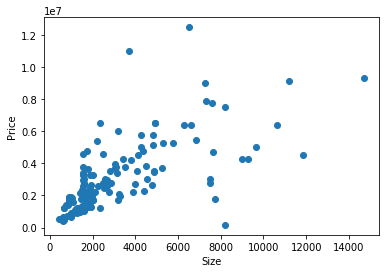

In [9]:
# filter to keep only houses with at least Price and Size
print("size of the dataset:", len(data), len(data[(pd.isna(data.price)==False) & (pd.isna(data.sqft)==False)]))

data = data[(pd.isna(data.price)==False) & (pd.isna(data.sqft)==False)]

plt.scatter(data.sqft, data.price);
plt.xlabel("Size")
plt.ylabel("Price");

In [10]:
# What is this strangely low priced big house?
data[data.price ==data.price.min()]

,address,city,state,zip,price,sqft,bedrooms,bathrooms,days_on_zillow,sale_type,url
72,21st Pl,Santa Monica,CA,90402,164000.0,8180.0,5.0,8.0,235.0,Pre-Foreclosure (Auction),http://www.zillow.com/homes/for_sale/126588922...


### Visualization of the cost on the ($\theta_0$, $\theta_1$) space

We're dealing with a very simple linear model here, we only have one feature (the size of the house) to predict the price. So our model is basically a line defined by an intercept ($\theta_0$) and a slope ($\theta_1$).

Let's see what the cost $J(\theta)$ that we can compute from the data in this dataset looks like over a space of $(\theta_0, \theta_1)$ values.

Numpy provides `np.meshgrid` as a convenience to create a grid of parameter over which to compute functions. By using it, we will create grids of $\theta_0$ and $\theta_1$ parameters, so we need to modify the cost function so it can do the right computation using grids instead of vectors. We will work with vectors.


#### Feature scaling/normalization

To improve the algorithm performance, we will scale our features by substracting the mean and dividing by the standard deviation.

THETA0 shape: (500, 500), THETA1 shape: (500, 500), features shape: (142, 1), trueValues shape: (142, 1)


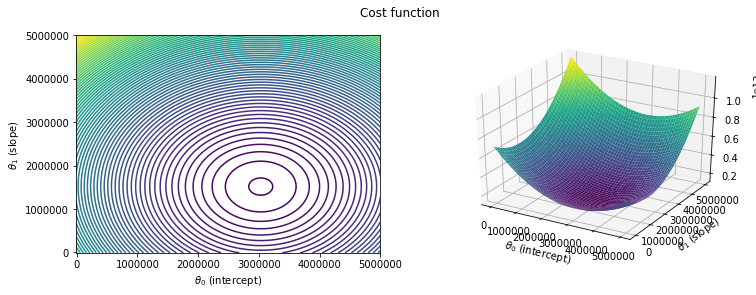

In [11]:
intercept = np.linspace(-10000, 5000000, 500) # range of values for the intercept we want to cover
slope = np.linspace(-10000, 5000000, 500) # range of values for the slope we want to cover

# let's create all the different (intercept, slope) pairs from those ranges of values
# we can use np.meshgrid for that and then ravel the vectors and concatenate them into a proper theta matrix.
# The THETA matrix will be a (2 x number of pairs) matrix
THETA0, THETA1 = np.meshgrid(intercept, slope)


# Feature normalization
mu = data.sqft.mean() # mean
sigma = data.sqft.std() # std
SIZE = ((data.sqft - mu)/sigma).values
TRUEVALUES = data.price.values # no normalization of target

# reshaping features and trueValues vectors
features = SIZE[:, np.newaxis]
trueValues = TRUEVALUES[:, np.newaxis]

print(f"THETA0 shape: {THETA0.shape}, THETA1 shape: {THETA1.shape}, features shape: {features.shape}, trueValues shape: {trueValues.shape}")

# define new prediction function to work with vectors, return prediction from a line equation
def computePrediction(theta0, theta1, features):
    return theta0 + theta1*features

# cost function that can handle meshgrids
# uses broadcasting abilities of numpy.
# CANNOT BE GENERALIZED TO MORE DIMENSIONS WITH THE CURRENT IMPLEMENTATION
def costFuncGrid(theta, features, trueValues):
    theta0, theta1 = theta
    # add a dimension to theta0 and theta1 over which we will sum everything later
    theta0 = theta0[:, np.newaxis]
    theta1 = theta1[:, np.newaxis]
    features = features*np.ones_like(theta1)
    prediction = computePrediction(theta0, theta1, features)
    return np.sum((prediction-trueValues)**2, axis=1)/(2*features.shape[1])

costValueGrid = costFuncGrid([THETA0, THETA1], features, trueValues)

# visualization of our cost function on the (theta0, theta1) space
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(122, projection='3d')
fig.suptitle("Cost function")

# 2D viz
ax1.contour(THETA0, THETA1, costValueGrid, 80)
ax1.set_xlabel(r"$\theta_0$ (intercept)")
ax1.set_ylabel(r"$\theta_1$ (slope)")

# 3D viz
ax2.plot_surface(THETA0, THETA1, costValueGrid, cmap="viridis")
ax2.set_xlabel(r"$\theta_0$ (intercept)")
ax2.set_ylabel(r"$\theta_1$ (slope)");

# Gradient Descent algorithm for simple linear regression

Alright, now that we have set up our cost function space and we've seen it's a convex function, let's use gradient descent to find the minimum.

The Gradient Descent algorithm will iterate over the cost function space by checking each time which direction on this plane is the steepest down, and will update $\theta_0$ and $\theta_1$ accordingly to the $\alpha$ rate for which you wanted your algorithm to learn. Note that if $\alpha$ is too low, it will take a long time before reaching convergence, and if it is too high, then you'll go away form the minimum as you'll bounce on the "walls" of the convex plane (we'll visualize that too).

For each $j=(0,1): \theta_j$, repeat until convergence:

$\theta_j := \theta_j-\alpha\frac{\delta}{\delta\theta_j}J(\theta_j)$ 

with $J(\theta_0, \theta_1)$ being the same cost function $J(\theta_j)=\frac{1}{2m}\sum_{i=1}^{m}(h_0(x^{(i)})-y^{(i)})^2$ that we used previously,

and $j=(0,1): \frac{\delta}{\delta\theta_j}J(\theta_j)=\frac{1}{m}\sum_{i=1}^{i=m}(h_0(x^{(i)})-y^{(i)})\times x_j^{(i)}$ being the derivative of this cost function (remember that $x_0=1$).

This is this derivative that we need to compute in the gradient descent algorithm.

In [136]:
# we'll make this function a generator so we can get all the steps the algorithm went over
def gradientDescent(startingTheta, features, trueValues, alpha=0.1, maxIterations=1000):    
    # number of data in training set
    m = np.array(features).shape[0]
    
    # We'll compare the theta vector to the next iteration to check convergence
    newTheta = startingTheta
    theta = np.ones_like(newTheta)
    
    i = 0 # we are setting up a counter to limit max number of iterations if algorithm doesn't converge
    while (newTheta!=theta).all():
        theta = newTheta
        prediction = np.dot(features, theta)
        # derivative for each theta
        derivative = (alpha/m)*np.sum((prediction - trueValues)*features, axis=0)[:, np.newaxis]
        newTheta = newTheta - derivative
        # in case there is no convergence
        i+=1
        if i>=maxIterations:
            break
        yield(np.ravel(newTheta))



# Initial [intercept,slope] values we'll start iterating from
initialTheta = np.array([50, 3])[:, np.newaxis]
# reshaping features and trueValues vectors
features = np.vstack([np.ones(len(SIZE)), (SIZE-SIZE.mean())/SIZE.std()]).transpose()
trueValues = TRUEVALUES[:, np.newaxis]

# we'll run gradient descent with different alpha rates
alphaList = [0.1, 0.3, 0.5, 1.5, 2.1]

gdList = [gradientDescent(initialTheta, features, trueValues, alpha=i) for i in alphaList]

descentList = [np.vstack([initialTheta.transpose(), np.vstack(list(gd))]) for gd in gdList]

Great, everything ran smoothly, and we stored the steps for different $\alpha$ learning rate.

Let's visualize how it looks on the cost function space that we computed previously.

(-10000.0, 5000000.0)

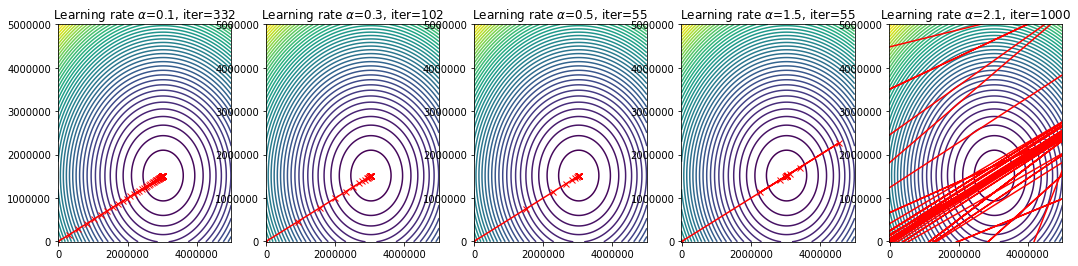

In [137]:
fig,axes = plt.subplots(ncols=len(alphaList), figsize=(18, 4))

for i in range(len(alphaList)):
    axes[i].contour(THETA0, THETA1, costValueGrid, 50)
    axes[i].plot(descentList[i][:, 0], descentList[i][:, 1], "-x", color="red")
    axes[i].set_title(r"Learning rate $\alpha$" f"={alphaList[i]}, iter={len(descentList[i])}")
    
# no convergence for alpha=2.1, let's rescale our graph
axes[4].set_xlim(intercept.min(), intercept.max())
axes[4].set_ylim(slope.min(), slope.max())

We see that for $\alpha=$, the learning rate is too high, and we bounce back and forth on the wall of the plane, getting farther and farther from the bottom of the bowl.

Let's see that in 3D;

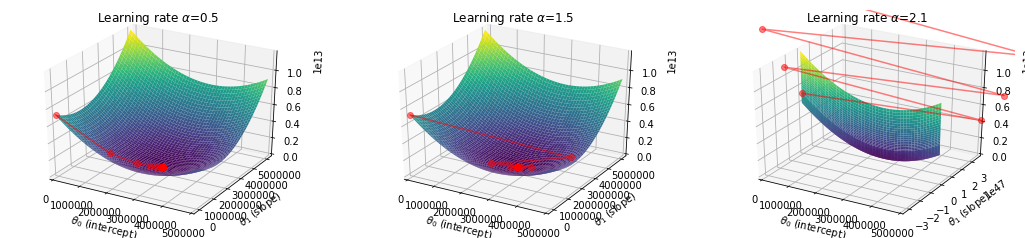

In [138]:
fig,axes = plt.subplots(ncols=len(alphaList)-2, figsize=(18, 4), subplot_kw={"projection": '3d'})

for i in range(len(alphaList)-2):
    theta = descentList[i+2].transpose()
    axes[i].set_title(r"Learning rate $\alpha$" f"={alphaList[i+2]}")
    axes[i].plot_surface(THETA0, THETA1, costValueGrid, cmap="viridis")
    axes[i].plot(np.ravel(descentList[i+2][:, 0]), np.ravel(descentList[i+2][:, 1]), np.ravel(computeCost(theta, features, trueValues)), "-o", color="red", alpha=0.5)
    axes[i].set_xlim(intercept.min(), intercept.max())
    axes[i].set_xlim(slope.min(), slope.max())
    axes[i].set_zlim(0, costValueGrid.max())
    axes[i].set_xlabel(r"$\theta_0$ (intercept)")
    axes[i].set_ylabel(r"$\theta_1$ (slope)");

In [139]:
costValues = [np.ravel(computeCost(theta.transpose(), features, trueValues)) for theta in descentList]
costDataDf = pd.DataFrame(index=range(np.max([len(c) for c in costValues])), columns=[f"alpha {alpha}" for alpha in alphaList])
for i,alpha in enumerate(alphaList):
    theta = descentList[i].transpose()
    costDataDf.loc[:len(costValues[i])-1, f"alpha {alpha}"] = np.ravel(computeCost(theta, features, trueValues))
#convert to long form data
costDataDf["iteration"] = costDataDf.index
costDataDf_Long = pd.melt(costDataDf, id_vars=['iteration'], value_vars=costDataDf.columns[:-1])

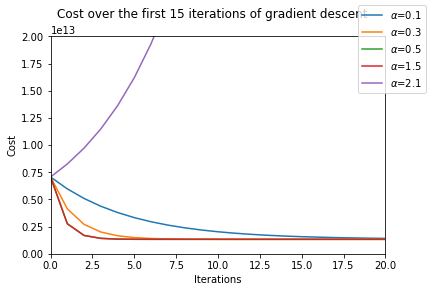

In [140]:
fig,ax = plt.subplots()

for i in range(len(alphaList)):
    theta = descentList[i].transpose()
    ax.plot(costValues[i], label=r"$\alpha$" f"={alphaList[i]}")
ax.set_xlim(0, 20)
ax.set_ylim(0, 2e13)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
fig.suptitle("Cost over the first 15 iterations of gradient descent")
fig.legend();

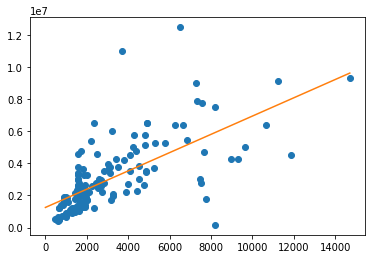

In [141]:
# Unscale the linear regression coefficients (they were obtained after feature scaling)
# let's define a function for that
import copy

def unscaleTheta(coefs, df, orderedFeatureNames):
    newCoefs = copy.deepcopy(coefs)
    n = newCoefs.shape[1]
    for i in range(len(orderedFeatureNames)):
        feature = orderedFeatureNames[i]
        newCoefs[:, 0] = newCoefs[:, 0] - (newCoefs[:, i+1]*df[feature].mean()/df[feature].std())
        newCoefs[:, i+1] = newCoefs[:, i+1]/df[feature].std()
    return newCoefs

descentListUnscaled = copy.deepcopy(descentList)

for i in range(len(descentListUnscaled)):    
    coefStepsUnscaled = descentListUnscaled[i]
    coefStepsUnscaled[:, 0] = coefStepsUnscaled[:, 0] - (coefStepsUnscaled[:, 1]*mu/sigma)
    coefStepsUnscaled[:, 1] = coefStepsUnscaled[:, 1]/sigma
    
 
# Let's see what the linear regression look like on the data
p = descentListUnscaled[1][-1][::-1]

plt.plot(data.sqft, data.price, "o")
plt.plot([0, data.sqft.max()], np.polyval(p, [0, data.sqft.max()]))



### Accuracy of our model

Now that gradient descent has converged toward a minimum, we could predict the prices of the houses based on the sizes by using those $\theta$.

We could then calculate the $RMSE$ to evaluate the accuracy of our model.

In [142]:
# let's get the theta obtained with alph=0.2
fittedTheta = descentList[2][-1][:, np.newaxis]

# predicted prices for all the houses
predictions = features@fittedTheta

def rmse(actual, prediction):
    n = len(prediction)
    return np.sqrt(np.sum(np.power(prediction - actual, 2))/n)

rmse(trueValues, predictions)

1631312.694692068

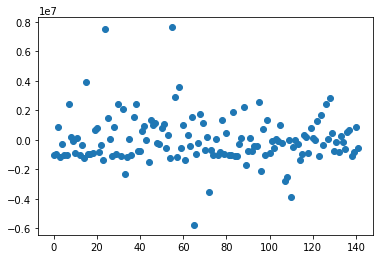

In [143]:
# residual plot
plt.plot(trueValues-predictions, "o");

# Multivariate regression

What if instead of just wanting to predict the price of the houses by just looking at the sizes, we wanted to also include other features, like the number of bedrooms, etc ...?

We would have more features, and our regression model would be defined as (with $x_0=1$):

$$y=\theta_0\times x_0 +\theta_1\times x_1 +... + \theta_n\times x_n$$

By adding more features, we could think that maybe our predictions would be better.

Let's see how our predictions would change.

Like we did above, we need to scale our features so all of their values could be "comparable"! Again, one option is (for each feature) to substrack the mean and then divide by the standard deviation.


In [150]:
featuresOfInterest = ["sqft", "bedrooms", "bathrooms"]

normalizedData = data[np.concatenate([["price"], featuresOfInterest])].dropna()
normalizedFeatures = (normalizedData[featuresOfInterest]-normalizedData[featuresOfInterest].mean())/normalizedData[featuresOfInterest].std()
normalizedFeatures.head()

,sqft,bedrooms,bathrooms
0,-0.832325,-0.840998,-0.860795
1,-0.585818,-0.553514,-0.282617
2,-0.520321,-0.553514,-0.571706
3,-0.762462,-0.553514,-0.571706
4,-0.313509,-0.266030,-0.282617


In [151]:
# reshaping features and trueValues vectors
features = np.hstack([np.ones(len(normalizedFeatures))[:, np.newaxis], normalizedFeatures])
trueValues = normalizedData.price.values[:, np.newaxis]

# Initial theta values we'll start iterating from. We now have 3 features, so must be size 4
initialTheta = np.random.rand(features.shape[1])[:, np.newaxis]

# we'll run gradient descent with different alpha rates
alphaList = [0.1, 0.3, 0.5]

gdList = [gradientDescent(initialTheta, features, trueValues, alpha=i, maxIterations=1000) for i in alphaList]
descentList = [np.vstack([initialTheta.transpose(), np.vstack(list(gd))]) for gd in gdList]

(0, 30)

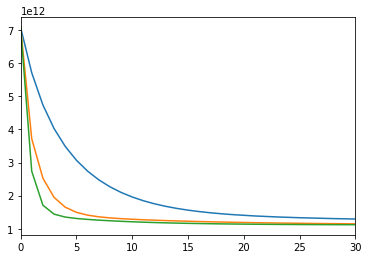

In [152]:
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[0]])
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[1]])
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[2]])
plt.xlim(0, 30)

In [154]:
# let's get the theta obtained with alph=0.2
fittedTheta = descentList[2][-1][:, np.newaxis]
nonNormalizedFeatures = np.hstack([np.ones(len(normalizedData[featuresOfInterest]))[:, np.newaxis], normalizedData[featuresOfInterest]])
predictions = features@fittedTheta

rmse(trueValues, predictions)

1493338.8199214682

In [155]:
normalizedData.loc[:, ["price"]].assign(predicted= lambda x: features@fittedTheta)

,price,predicted
0,698000.0,1.744963e+06
1,1099000.0,2.318971e+06
2,2999000.0,2.229162e+06
3,680000.0,1.744001e+06
4,2200000.0,2.502594e+06
5,849000.0,1.795699e+06
6,549000.0,1.549308e+06
7,7895000.0,6.657646e+06
8,2329000.0,1.796393e+06
9,2695000.0,2.390978e+06


Text(0,0.5,'Predicted Price')

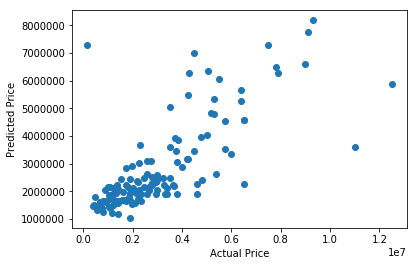

In [107]:
plt.plot(normalizedData.price, predictions, "o")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

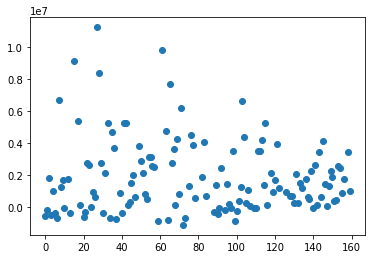

In [89]:
# Residuals plot
plt.plot(normalizedData.price-np.ravel(features@fittedTheta), "o")

Let's try to improve those prediction by adding the zip code, encoded as hotshot

In [139]:
data.zip.unique()

array([90403, 90402, 90405, 90401, 90404])

In [140]:
dataEncoded = data[np.concatenate([["price", "zip"], featuresOfInterest])].dropna().assign(zip90401 = lambda x: (x.zip==90401).astype(int))
dataEncoded = dataEncoded.assign(zip90402 = lambda x: (x.zip==90402).astype(int))
dataEncoded = dataEncoded.assign(zip90403 = lambda x: (x.zip==90403).astype(int))
dataEncoded = dataEncoded.assign(zip90404 = lambda x: (x.zip==90404).astype(int))
dataEncoded = dataEncoded.assign(zip90405 = lambda x: (x.zip==90405).astype(int))
dataEncoded.loc[:, featuresOfInterest] = (dataEncoded.loc[:, featuresOfInterest]-dataEncoded.loc[:, featuresOfInterest].mean())/dataEncoded.loc[:, featuresOfInterest].std()
dataEncoded.head()

,price,zip,sqft,bedrooms,bathrooms,zip90401,zip90402,zip90403,zip90404,zip90405
0,698000.0,90403,-0.832325,-0.840998,-0.860795,0,0,1,0,0
1,1099000.0,90403,-0.585818,-0.553514,-0.282617,0,0,1,0,0
2,2999000.0,90402,-0.520321,-0.553514,-0.571706,0,1,0,0,0
3,680000.0,90403,-0.762462,-0.553514,-0.571706,0,0,1,0,0
4,2200000.0,90405,-0.313509,-0.266030,-0.282617,0,0,0,0,1


In [141]:
# features now also includes number of beds and number of bathrooms
features = np.hstack([np.ones(len(dataEncoded))[:, np.newaxis], dataEncoded.loc[:, "sqft":].values])
trueValues = dataEncoded.price.values[:, np.newaxis]

# Initial theta values we'll start iterating from. We now have 3 features, so must be size 4
initialTheta = np.random.rand(features.shape[1])[:, np.newaxis]

# we'll run gradient descent with different alpha rates
alphaList = [0.005, 0.01, 0.05]

gdList = [gradientDescent(initialTheta, features, trueValues, alpha=i, maxIterations=1000) for i in alphaList]
descentList = [np.vstack([initialTheta.transpose(), np.vstack(list(gd))]) for gd in gdList]

In [142]:
# let's get the theta obtained with alph=0.2
fittedTheta = descentList[2][-1][:, np.newaxis]

predictions = features@fittedTheta

rmse(trueValues, predictions)

1332921.2497598487

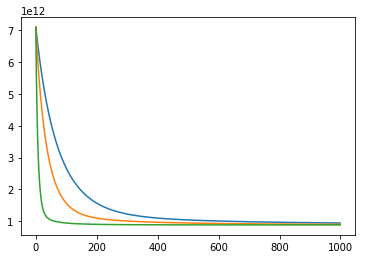

In [143]:
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[0]])
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[1]])
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[2]])

In [144]:
dataEncoded.loc[:, ["price"]].assign(predicted= lambda x: features@fittedTheta)
# data.assign(predicted = lambda x: features@fittedTheta)

,price,predicted
0,698000.0,1.112635e+06
1,1099000.0,1.700479e+06
2,2999000.0,3.218654e+06
3,680000.0,1.219213e+06
4,2200000.0,2.073156e+06
5,849000.0,1.256968e+06
6,549000.0,2.191086e+06
7,7895000.0,7.004660e+06
8,2329000.0,1.303395e+06
9,2695000.0,1.982374e+06


Text(0,0.5,'Predicted Price')

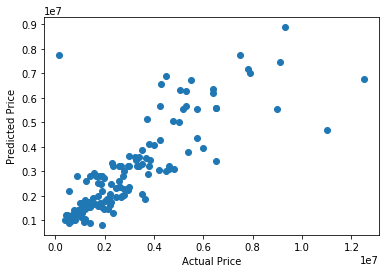

In [145]:
plt.plot(dataEncoded.price, features@fittedTheta, "o")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

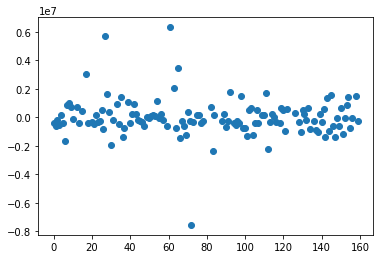

In [146]:
# Residuals plot
plt.plot(dataEncoded.price-np.ravel(features@fittedTheta), "o")

# Scikit learn

In [147]:
import sklearn
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(dataEncoded.loc[:, "sqft":].values, dataEncoded.loc[:, "price"].values)

print(f"intercept: {lm.intercept_}")
print(f"number of coefs: {len(lm.coef_)}")

intercept: 2975656.552691245
number of coefs: 8


Text(0,0.5,'Predicted Price')

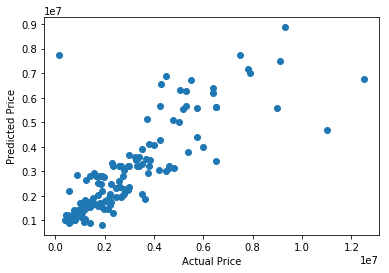

In [148]:
plt.plot(dataEncoded.price, lm.predict(dataEncoded.loc[:, "sqft":].values), "o")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

In [149]:
# comparing with the manual gradient descent
dataEncoded.loc[:, ["price"]].assign(predicted= lambda x: features@fittedTheta).assign(sklearn= lambda x: lm.predict(dataEncoded.loc[:, "sqft":].values))



,price,predicted,sklearn
0,698000.0,1.112635e+06,1.110926e+06
1,1099000.0,1.700479e+06,1.701139e+06
2,2999000.0,3.218654e+06,3.214855e+06
3,680000.0,1.219213e+06,1.217260e+06
4,2200000.0,2.073156e+06,2.073267e+06
5,849000.0,1.256968e+06,1.255056e+06
6,549000.0,2.191086e+06,2.208658e+06
7,7895000.0,7.004660e+06,7.007702e+06
8,2329000.0,1.303395e+06,1.299082e+06
9,2695000.0,1.982374e+06,1.980082e+06


Text(0,0.5,'Prediction by coded gradient descent')

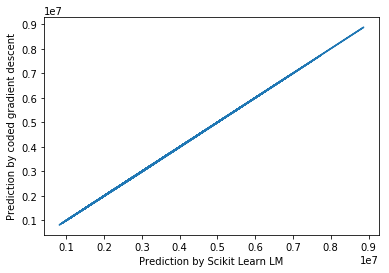

In [150]:
plt.plot(lm.predict(dataEncoded.loc[:, "sqft":].values), features@fittedTheta)
plt.xlabel("Prediction by Scikit Learn LM")
plt.ylabel("Prediction by coded gradient descent")

Great, we got the same results, quantitatively, than Scikit Learn

# Data from Andrew Ng class

In [151]:
data2 = pd.read_csv("../data/ex1data2.txt", header=None, names=['Size', 'Bedrooms', 'Price'])  
data2.head() 

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [152]:
normalizedFeatures = (data2[["Size", "Bedrooms"]] - data2[["Size", "Bedrooms"]].mean())/data2[["Size", "Bedrooms"]].std()

# features now also includes number of beds and number of bathrooms
features = np.hstack([np.ones(len(data2))[:, np.newaxis], normalizedFeatures.values])
trueValues = data2.Price.values[:, np.newaxis]

# Initial theta values we'll start iterating from. We now have 3 features, so must be size 4
initialTheta = np.random.rand(features.shape[1])[:, np.newaxis]

# we'll run gradient descent with different alpha rates
alphaList = [0.01, 0.05, 0.1]

gdList = [gradientDescent(initialTheta, features, trueValues, alpha=i, maxIterations=1000) for i in alphaList]
descentList = [np.vstack([initialTheta.transpose(), np.vstack(list(gd))]) for gd in gdList]

In [153]:
# let's get the theta obtained with alph=0.2
fittedTheta = descentList[0][-1][:, np.newaxis]

# predicted prices for all the houses
predictions = features@fittedTheta

rmse(trueValues, predictions)

63930.376363304626

In [154]:
computeCost(fittedTheta, features, trueValues)

array([2.04354651e+09])

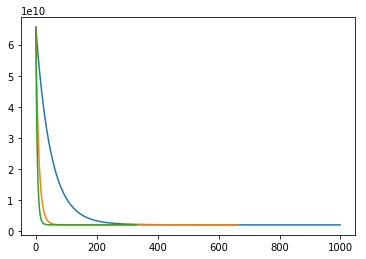

In [155]:
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[0]])
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[1]])
plt.plot([np.ravel(computeCost(theta[:, np.newaxis], features, trueValues)) for theta in descentList[2]])

In [156]:
data2.assign(predicted= lambda x: features@fittedTheta)

,Size,Bedrooms,Price,predicted
0,2104,3,399900,355990.122267
1,1600,3,329900,286326.696230
2,2400,3,369000,396903.562955
3,1416,2,232000,268598.623725
4,3000,4,539900,472131.606158
5,1985,4,299900,331837.206501
6,1534,3,314900,277204.104726
7,1427,3,198999,262414.448801
8,1380,3,212000,255918.057881
9,1494,3,242500,271675.261389


Text(0,0.5,'Predicted price')

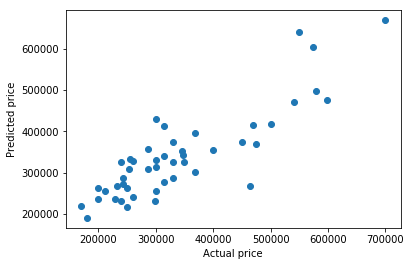

In [157]:
plt.plot(data2.Price, features@fittedTheta, "o")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")